In [366]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Data

In [5]:
# data = pd.read_csv("/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/WineData/cleansingWine.csv", low_memory=False)
data = pd.read_csv("/Users/Bnkes/Desktop/GitHub/AdvancedMachineLearning/Data/WineData/cleansingWine.csv", low_memory=False)
data = data.drop("Unnamed: 0", axis = 1)
data.head()

,id,name,producer,nation,local1,local2,local3,local4,varieties1,varieties2,...,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,137197,Altair,Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,Carmenere,...,Table,14~15,17~19,SWEET1,ACIDITY4,BODY5,TANNIN4,220000,2014,750
1,137198,"Altair, Sideral",Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,Merlot,...,Table,14~15,16~18,SWEET1,ACIDITY3,BODY4,TANNIN4,110000,2016,750
2,137199,Baron du Val Red,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,Cinsault,...,Table,11~12,15~17,SWEET2,ACIDITY3,BODY2,TANNIN2,0,0,750
3,137200,Baron du Val White,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,Ugni​ blanc,...,Table,11~12,9~11,SWEET1,ACIDITY3,BODY2,TANNIN1,0,0,750
4,137201,"Benziger, Cabernet Sauvignon",Benziger,USA,California,NaN,NaN,NaN,Cabernet Sauvignon,NaN,...,Table,13~14,17~19,SWEET1,ACIDITY3,BODY3,TANNIN4,0,2003,750


In [7]:
def remove_tilda(value):
    if "~" in value:
        values = value.split("~")
        avg = (float(value[0]) + float(value[-1]))/2
        return avg
    else:
        return float(value)

In [9]:
clean_data = data.drop(
    ["id", "name", "producer", "local3", "local4", "varieties2",
     "varieties3", "varieties4", "varieties5", "varieties6", "varieties7",
     "varieties8", "varieties9", "varieties10", "varieties11", "varieties12"], axis = 1)
clean_data = clean_data[(clean_data["price"] != 0) & (clean_data["year"] != 0)]
clean_data = clean_data.dropna(axis = 0)
clean_data["year"] = clean_data["year"].astype(str)
clean_data["abv"] = clean_data["abv"].apply(lambda x: remove_tilda(x))
clean_data["degree"] = clean_data["degree"].apply(lambda x: remove_tilda(x))
clean_data.reset_index(inplace=True, drop=True)
clean_data

,nation,local1,local2,varieties1,type,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,France,Southern France,Languedoc Roussillon,Cabernet Sauvignon,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY2,TANNIN3,19000,2017,750
1,France,Southern France,Languedoc Roussillon,Merlot,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY3,TANNIN3,19000,2011,750
2,France,Bordeaux,Premieres Cotes de Bordeaux,Semillon,White,Dessert,13.0,1.5,SWEET2,ACIDITY4,BODY3,TANNIN1,18000,2009,750
3,France,Bordeaux,Medoc,Cabernet Sauvignon,Red,Table,2.0,4.5,SWEET1,ACIDITY4,BODY3,TANNIN3,32000,2015,750
4,France,Bordeaux,SaintEmilion,Merlot,Red,Table,2.0,4.5,SWEET1,ACIDITY3,BODY2,TANNIN2,42000,2010,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4016,Italy,Toscana,Bolgheri,Cabernet Sauvignon,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY3,TANNIN3,250000,2007,750
4017,USA,California,Riverside County,Sangiovese,Rose,"Appetizer, Table",2.5,4.0,SWEET2,ACIDITY3,BODY2,TANNIN1,195000,2013,750
4018,USA,California,Napa County,Cabernet Sauvignon,Red,Table,3.0,4.5,SWEET1,ACIDITY3,BODY4,TANNIN4,475000,2006,750
4019,the Republic of South Africa,Coastal Region,Paarl,Chardonnay,White,"Appetizer, Table",2.0,1.5,SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750


In [11]:
ct = ColumnTransformer(
    [
        ("dummify", preprocessing.OneHotEncoder(sparse_output=False, handle_unknown="error", drop = "first"), make_column_selector(dtype_include=object)),
        ("standardize", preprocessing.StandardScaler(), make_column_selector(dtype_include=np.number))
    ], remainder = "passthrough"
)

## Neural Networks

### Regression Model
We will begin with a regression problem. We will build three different neural networks to solve this problem. We will begin with a very simple neural network to understand baseline performance. From there we will build a slightly more complex model, and then finally we will build a model to attempt to get the best results.

In [397]:
X = clean_data.drop("price", axis = 1)
X = ct.fit_transform(X)
y = clean_data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.25, random_state=1)

In [399]:
# Least Complex Model, includes only a single layer
inputs = keras.Input(shape=(453,))
x = layers.Dense(250, activation="relu")(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="wine_model_1")
model.summary()

Model: "wine_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)          │ (None, 453)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 250)                 │         113,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,751 (444.34 KB)

 Trainable params: 113,751 (444.34 KB)

 Non-trainable params: 0 (0.00 B)

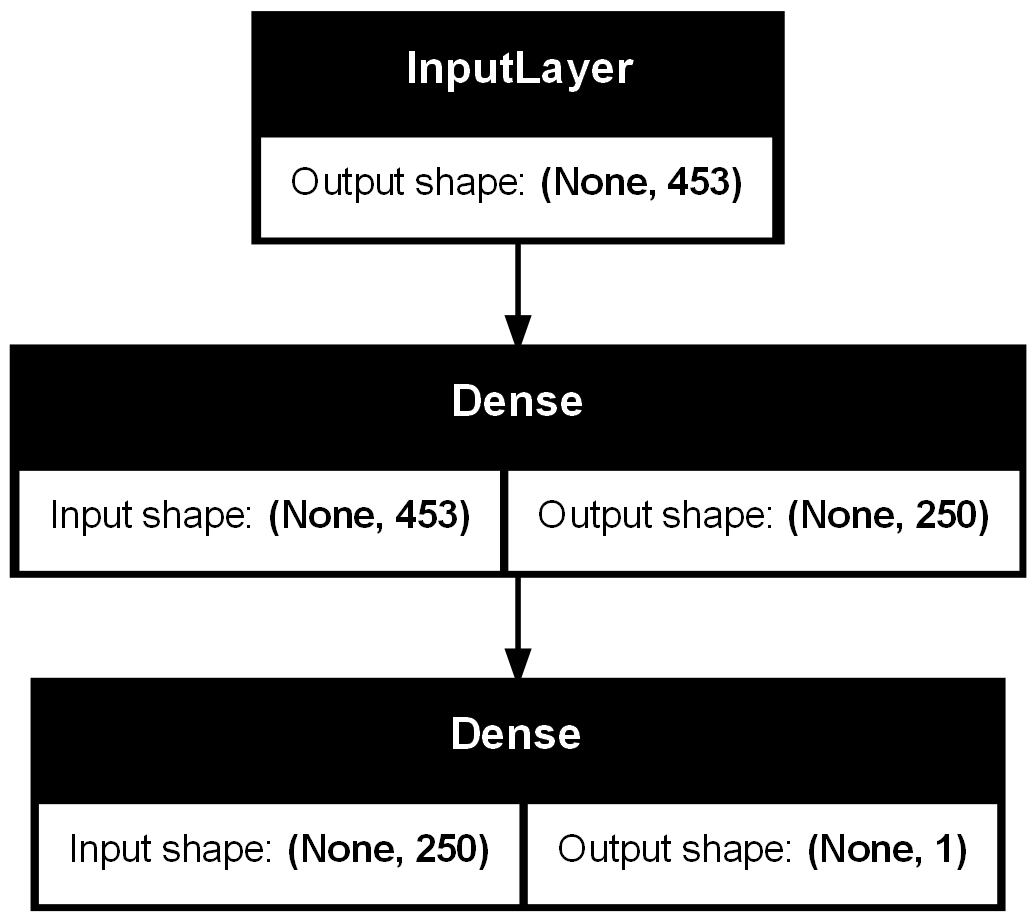

In [401]:
keras.utils.plot_model(model, show_shapes = True)

In [403]:
model.compile(
    loss = keras.losses.Huber(delta=1.0),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.R2Score],
)

history = model.fit(X_train, y_train, batch_size = 64, epochs=100, validation_split=.2)

In [406]:
scores = model.evaluate(X_test, y_test, verbose=2)

95/95 - 0s - 621us/step - loss: 171939.4219 - r2_score: -3.6044e-01


As can be seen above, the very simple neural network did not do a good job at accurately predicting the price of the wine. This is expected as it is a single layer neural network. Next we will create a more complex network with more layers and use a linear activation function.

In [418]:
inputs = keras.Input(shape=(453,))
x = layers.Dense(400, activation="linear")(inputs)
x = layers.Dense(200, activation="linear")(x)
x = layers.Dense(100, activation="linear")(x)
x = layers.Dense(20, activation="linear")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="wiine_model_2")
model.summary()

Model: "wiine_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)          │ (None, 453)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 400)                 │         181,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 200)                 │          80,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 20)                  │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,941 (1.08 MB)

 Trainable params: 283,941 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

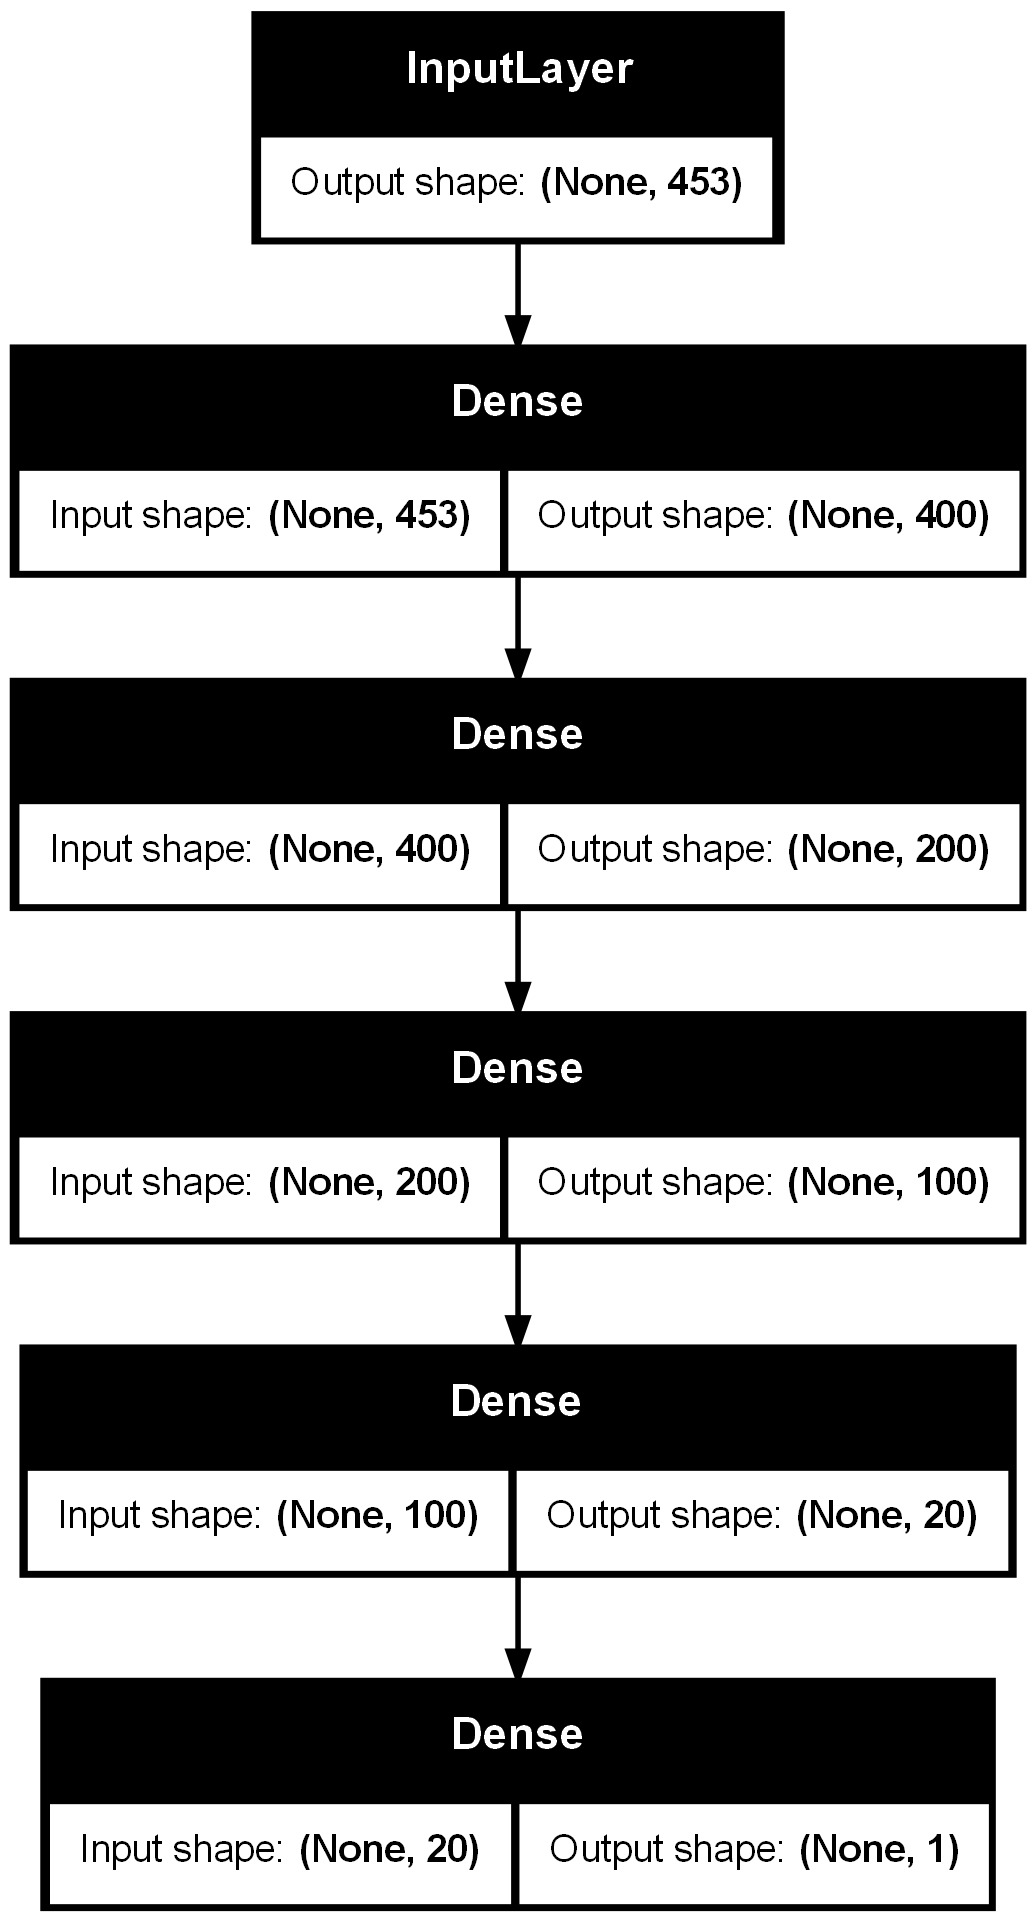

In [420]:
keras.utils.plot_model(model, show_shapes = True)

In [424]:
model.compile(
    loss = keras.losses.Huber(delta=1.0),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.R2Score],
)

history = model.fit(X_train, y_train, batch_size = 64, epochs=100, validation_split=.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 178035.5312 - r2_score: -0.4505 - val_loss: 156145.7188 - val_r2_score: -0.7859
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 187174.9219 - r2_score: -0.4786 - val_loss: 155108.2344 - val_r2_score: -0.7752
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 179195.2344 - r2_score: -0.5556 - val_loss: 152073.4375 - val_r2_score: -0.7443
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 182117.9688 - r2_score: -0.4166 - val_loss: 145808.1094 - val_r2_score: -0.6825
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 172037.2031 - r2_score: -0.4294 - val_loss: 134871.5469 - val_r2_score: -0.5801
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 163194.4062 - r2_score: -0.3296 - val_loss: 119782.8750 - val_r2_score: -0.4404
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 141056.5000 - r2_score: -0.2784 - val_loss: 106611.6328 - val_r2_score: -0.2913
Epoch 8/100
13/13 ━━━━━━━━

In [426]:
scores = model.evaluate(X_test, y_test, verbose=2)

95/95 - 0s - 779us/step - loss: 89402.6172 - r2_score: 0.2577


With a slightly more complex neural network (more layers, more nodes -> more parameters), we were able to achieve an $R^2$ value of .26 which is a huge improvement from the negative $R^2$ value we were achieving with the last neural network. Now we will add in dropout layers to remove overfitting and add a little more complexity to the neural network.

In [461]:
inputs = keras.Input(shape=(453,))
x = layers.Dense(400, activation = 'linear')(inputs)
x = layers.Dropout(rate=.1)(x)
x = layers.Dense(200, activation = "linear")(x)
x = layers.Dropout(rate = .1)(x)
x = layers.Dense(100, activation = "linear")(x)
x = layers.Dropout(rate = .1)(x)
x = layers.Dense(50, activation = "linear")(x)
x = layers.Dropout(rate = .1)(x)
x = layers.Dense(20, activation="linear")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="wine_model_3")
model.summary()

Model: "wine_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)          │ (None, 453)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 400)                 │         181,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 200)                 │          80,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,991 (1.10 MB)

 Trainable params: 287,991 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

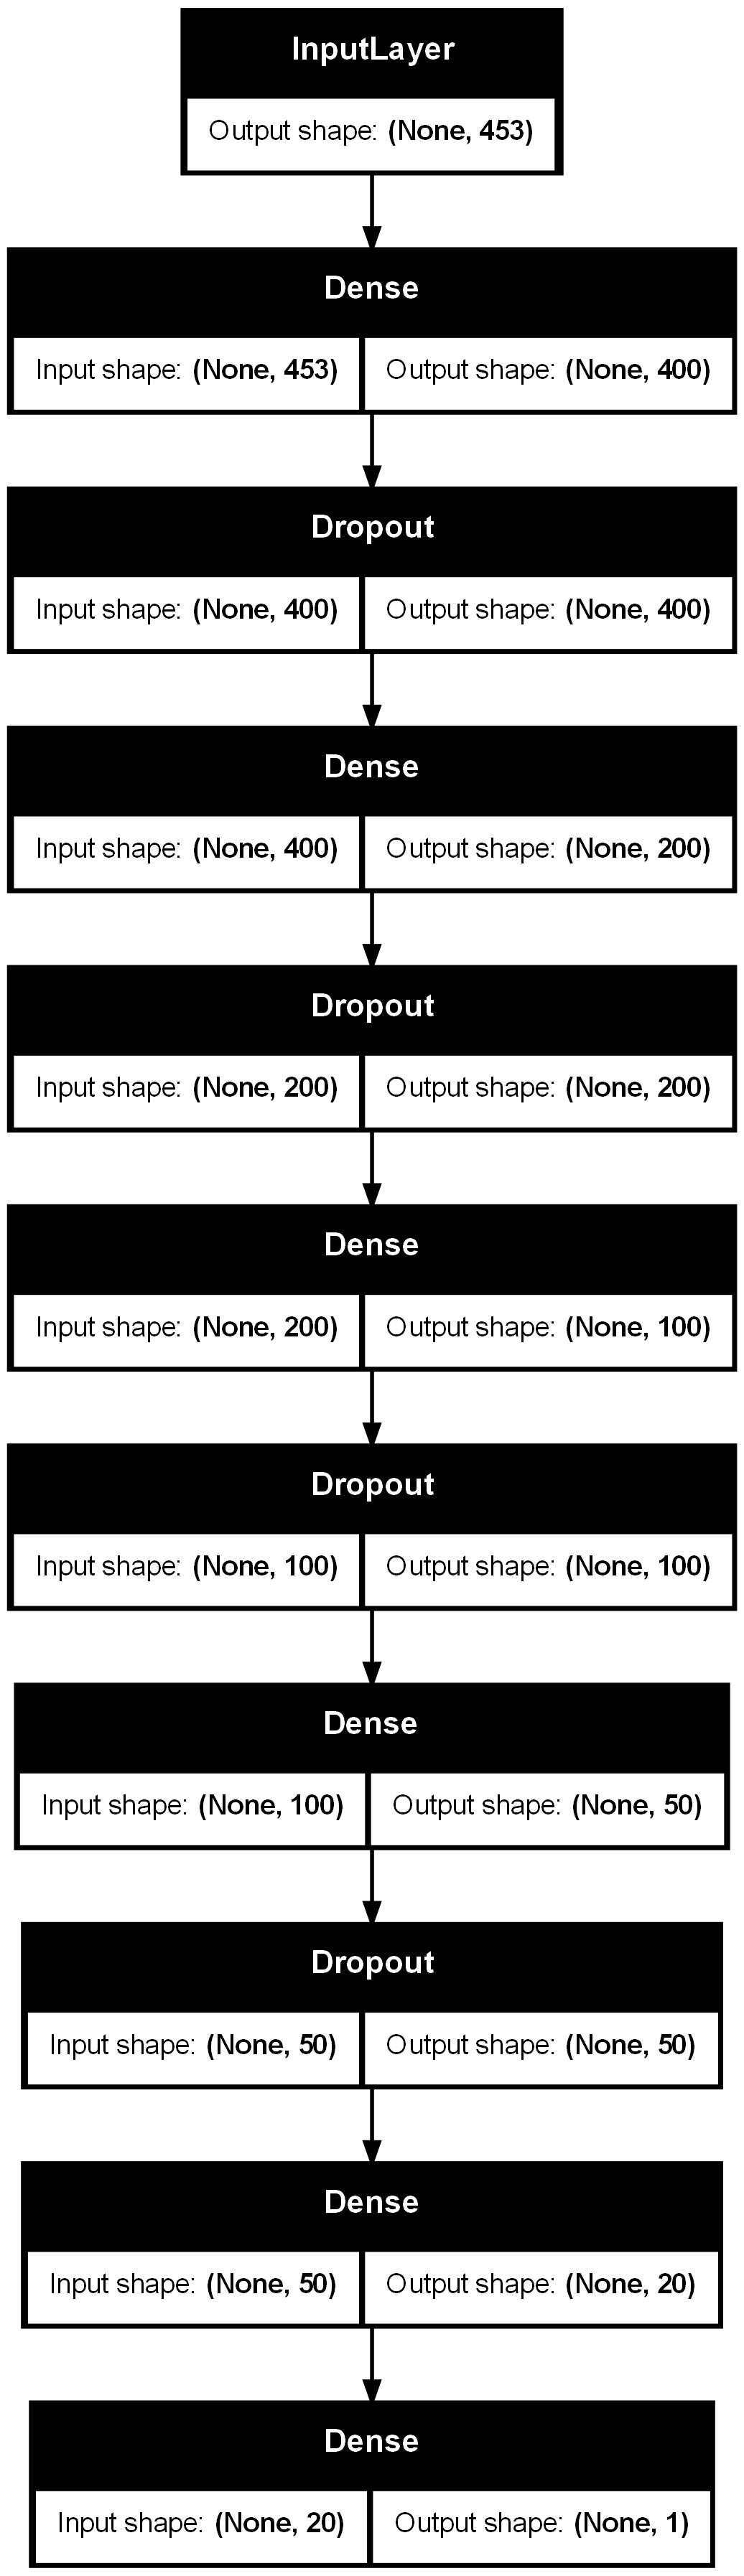

In [463]:
keras.utils.plot_model(model, show_shapes = True)

In [457]:
model.compile(
    loss = keras.losses.Huber(delta=1.0),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.R2Score],
)

history = model.fit(X_train, y_train, batch_size = 64, epochs=100, validation_split=.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 195555.0938 - r2_score: -0.5070 - val_loss: 153622.8594 - val_r2_score: -0.7599
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 196879.6562 - r2_score: -0.4456 - val_loss: 126721.6328 - val_r2_score: -0.5048
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 148779.9688 - r2_score: -0.3035 - val_loss: 99922.4688 - val_r2_score: -0.1592
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 119994.4141 - r2_score: -0.1090 - val_loss: 97256.0078 - val_r2_score: -0.0180
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 115426.7109 - r2_score: -0.0296 - val_loss: 94611.8047 - val_r2_score: -0.0275
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 133800.2969 - r2_score: -0.0364 - val_loss: 92649.2969 - val_r2_score: 0.0267
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 134688.3594 - r2_score: -0.0199 - val_loss: 90690.5703 - val_r2_score: 0.0855
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━

In [458]:
scores = model.evaluate(X_test, y_test, verbose=2)

95/95 - 0s - 811us/step - loss: 93757.0625 - r2_score: 0.2070


Adding in the dropout layers and additional nodes has not increased the performance of the model. It appears that while these layers are useful if overfitting is a problem, when the accuracy of the model is already fairly low they tend to further decrease its accuracy. I will attempt one last model with a large amount of parameters.

In [472]:
inputs = keras.Input(shape=(453,))
x = layers.Dense(450, activation="relu")(inputs)
x = layers.Dense(400, activation="relu")(x)
x = layers.Dense(350, activation="relu")(x)
x = layers.Dense(300, activation="relu")(x)
x = layers.Dense(250, activation="relu")(x)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dense(150, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(25, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="wine_model_4")
model.summary()

Model: "wine_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)          │ (None, 453)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 450)                 │         204,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 400)                 │         180,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 350)                 │         140,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 300)                 │         105,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 250)                 │          75,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 200)                 │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 100)                 │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_161 (Dense)                    │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_162 (Dense)                    │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 807,401 (3.08 MB)

 Trainable params: 807,401 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

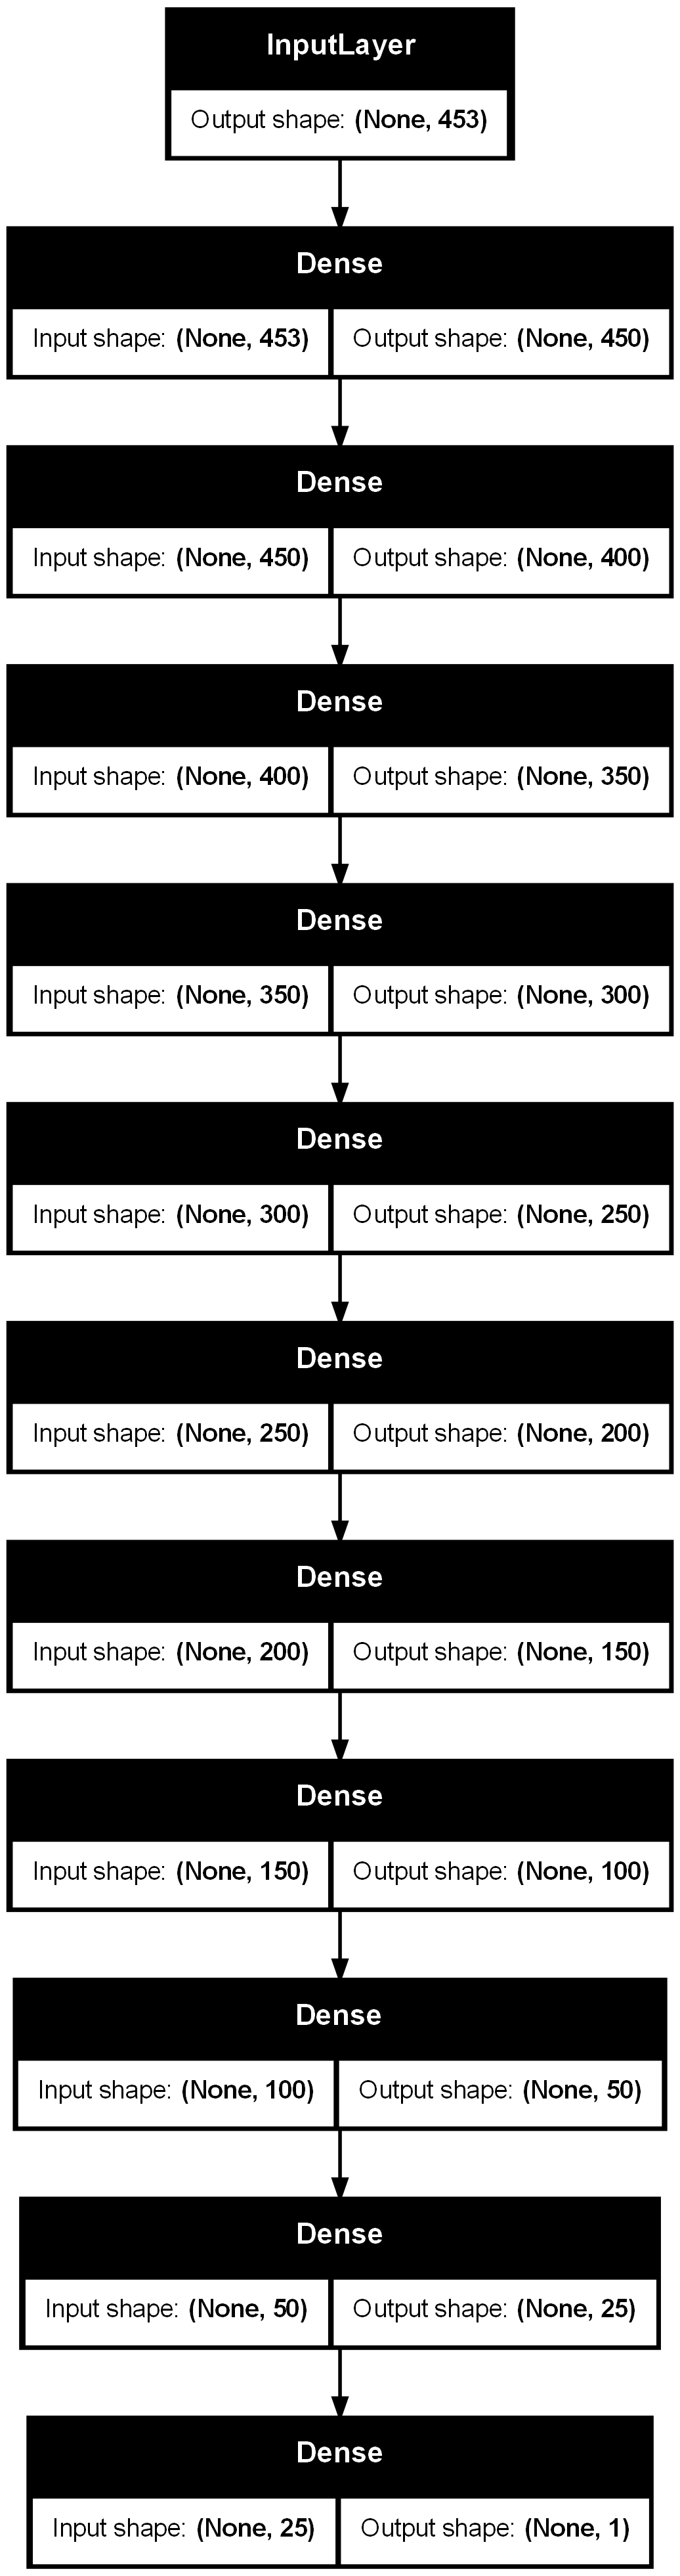

In [474]:
keras.utils.plot_model(model, show_shapes = True)

In [476]:
model.compile(
    loss = keras.losses.Huber(delta=1.0),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.R2Score],
)

history = model.fit(X_train, y_train, batch_size = 64, epochs=100, validation_split=.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 194058.7188 - r2_score: -0.4494 - val_loss: 99923.0469 - val_r2_score: -0.1407
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 139884.0000 - r2_score: -0.0741 - val_loss: 98441.0078 - val_r2_score: 0.1309
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 117405.3594 - r2_score: 0.0358 - val_loss: 88550.9375 - val_r2_score: 0.1065
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 104354.4453 - r2_score: 0.0622 - val_loss: 85054.6172 - val_r2_score: 0.1984
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 105540.5234 - r2_score: 0.1405 - val_loss: 82346.6172 - val_r2_score: 0.2693
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 103022.7109 - r2_score: 0.1727 - val_loss: 80183.5391 - val_r2_score: 0.3154
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 103932.2500 - r2_score: 0.2159 - val_loss: 77784.5547 - val_r2_score: 0.3253
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

In [478]:
scores = model.evaluate(X_test, y_test, verbose=2)

95/95 - 0s - 1ms/step - loss: 102595.1641 - r2_score: 0.2126


Even with this much larger neural network, the $R^2$ value did not improve. This suggests that to get even better performance layers other than just increasing size are necessary.

### Classification Model
Now we will switch to attempting to classify the nation where the wines are produced. We will do this with a series of neural networks. Building from a simple, single layer network, to a much more complex network.

In [483]:
X = clean_data.drop(["nation", "local1", "local2"], axis = 1)
X = ct.fit_transform(X)
y = clean_data["nation"]
y = preprocessing.LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.25, random_state=1)

In [485]:
nation_labels = clean_data["nation"].to_list()
nation_dict = dict(zip(y, nation_labels))

pred_columns = [f"Predicted {nation_dict[i]}" for i in range(17)]
actual_columns = [f"Actual {nation_dict[i]}" for i in range(17)]

In [490]:
inputs = keras.Input(shape=(172,))
x = layers.Dense(150, activation = "relu")(inputs)
outputs = layers.Dense(17, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="nation_model_1")
model.summary()

Model: "nation_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)          │ (None, 172)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_163 (Dense)                    │ (None, 150)                 │          25,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_164 (Dense)                    │ (None, 17)                  │           2,567 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,517 (111.39 KB)

 Trainable params: 28,517 (111.39 KB)

 Non-trainable params: 0 (0.00 B)

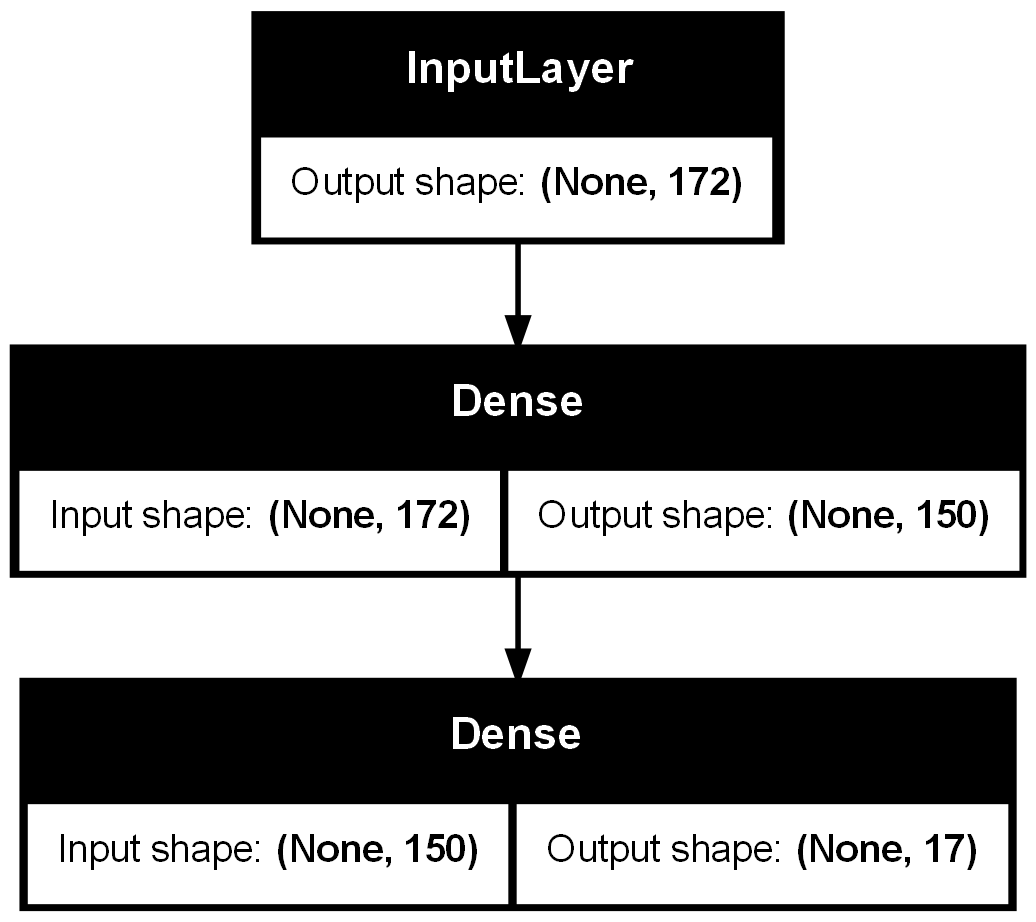

In [492]:
keras.utils.plot_model(model, show_shapes = True)

In [494]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.sparse_categorical_accuracy],
)

history = model.fit(X_train, y_train, batch_size = 64, epochs=50, validation_split=.2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7032 - sparse_categorical_accuracy: 0.1686 - val_loss: 2.2892 - val_sparse_categorical_accuracy: 0.3831
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1211 - sparse_categorical_accuracy: 0.4564 - val_loss: 1.9785 - val_sparse_categorical_accuracy: 0.4179
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8322 - sparse_categorical_accuracy: 0.4587 - val_loss: 1.8108 - val_sparse_categorical_accuracy: 0.4428
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6027 - sparse_categorical_accuracy: 0.5130 - val_loss: 1.7225 - val_sparse_categorical_accuracy: 0.4627
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5462 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.6617 - val_sparse_categorical_accuracy: 0.4975
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3752 - sparse_categorical_accuracy: 0.5806 - val_loss: 1.6024 - val_sparse_categorical_accuracy: 0.5075
Epoch 7/50
13/13

In [496]:
scores = model.evaluate(X_test, y_test, verbose=2)

95/95 - 0s - 558us/step - loss: 1.2068 - sparse_categorical_accuracy: 0.6250


In [498]:
y_pred_prob = model.predict(X_test)  # Get predicted probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=pred_columns, index = actual_columns)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step


,Predicted Argentina,Predicted Australia,Predicted Austria,Predicted Canada,Predicted Chile,Predicted France,Predicted Germany,Predicted Greece,Predicted Hungary,Predicted Italy,Predicted Japan,Predicted Korea,Predicted New Zealand,Predicted Portugal,Predicted Spain,Predicted USA,Predicted the Republic of South Africa
Actual Argentina,8,4,0,0,2,9,0,0,0,2,0,0,0,0,0,15,0
Actual Australia,0,95,0,0,11,102,0,0,0,2,0,0,2,0,0,60,2
Actual Austria,0,2,0,0,0,7,0,0,0,5,0,0,0,0,0,6,0
Actual Canada,0,0,0,3,1,5,0,0,0,0,0,0,3,0,0,3,0
Actual Chile,0,28,0,0,58,74,0,0,0,1,0,0,4,0,0,56,1
Actual France,1,48,0,0,28,817,0,0,0,13,0,0,9,0,0,124,5
Actual Germany,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Actual Greece,0,1,0,0,0,8,0,2,0,1,0,0,0,0,0,2,0
Actual Hungary,0,0,0,0,0,4,0,0,0,1,0,0,2,0,0,4,0
Actual Italy,0,3,0,0,5,44,0,0,0,475,0,0,0,0,0,22,0


For the simplicity of this first model, it does pretty well. The model seems to overpredict the predominant classes which could be a result of overfitting or a result of there being too few layers for the model to be able to distinguish the difference. We will now try adding more layers and changing the activation function for the layers.

In [501]:
inputs = keras.Input(shape=(172,))
x = layers.Dense(150)(inputs)
x = layers.LeakyReLU()(x)
x = layers.Dense(100)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(50)(x)
x = layers.LeakyReLU()(x)
outputs = layers.Dense(17, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="nation_model_1")
model.summary()

Model: "nation_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)          │ (None, 172)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 150)                 │          25,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 100)                 │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_167 (Dense)                    │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_168 (Dense)                    │ (None, 17)                  │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,967 (183.46 KB)

 Trainable params: 46,967 (183.46 KB)

 Non-trainable params: 0 (0.00 B)

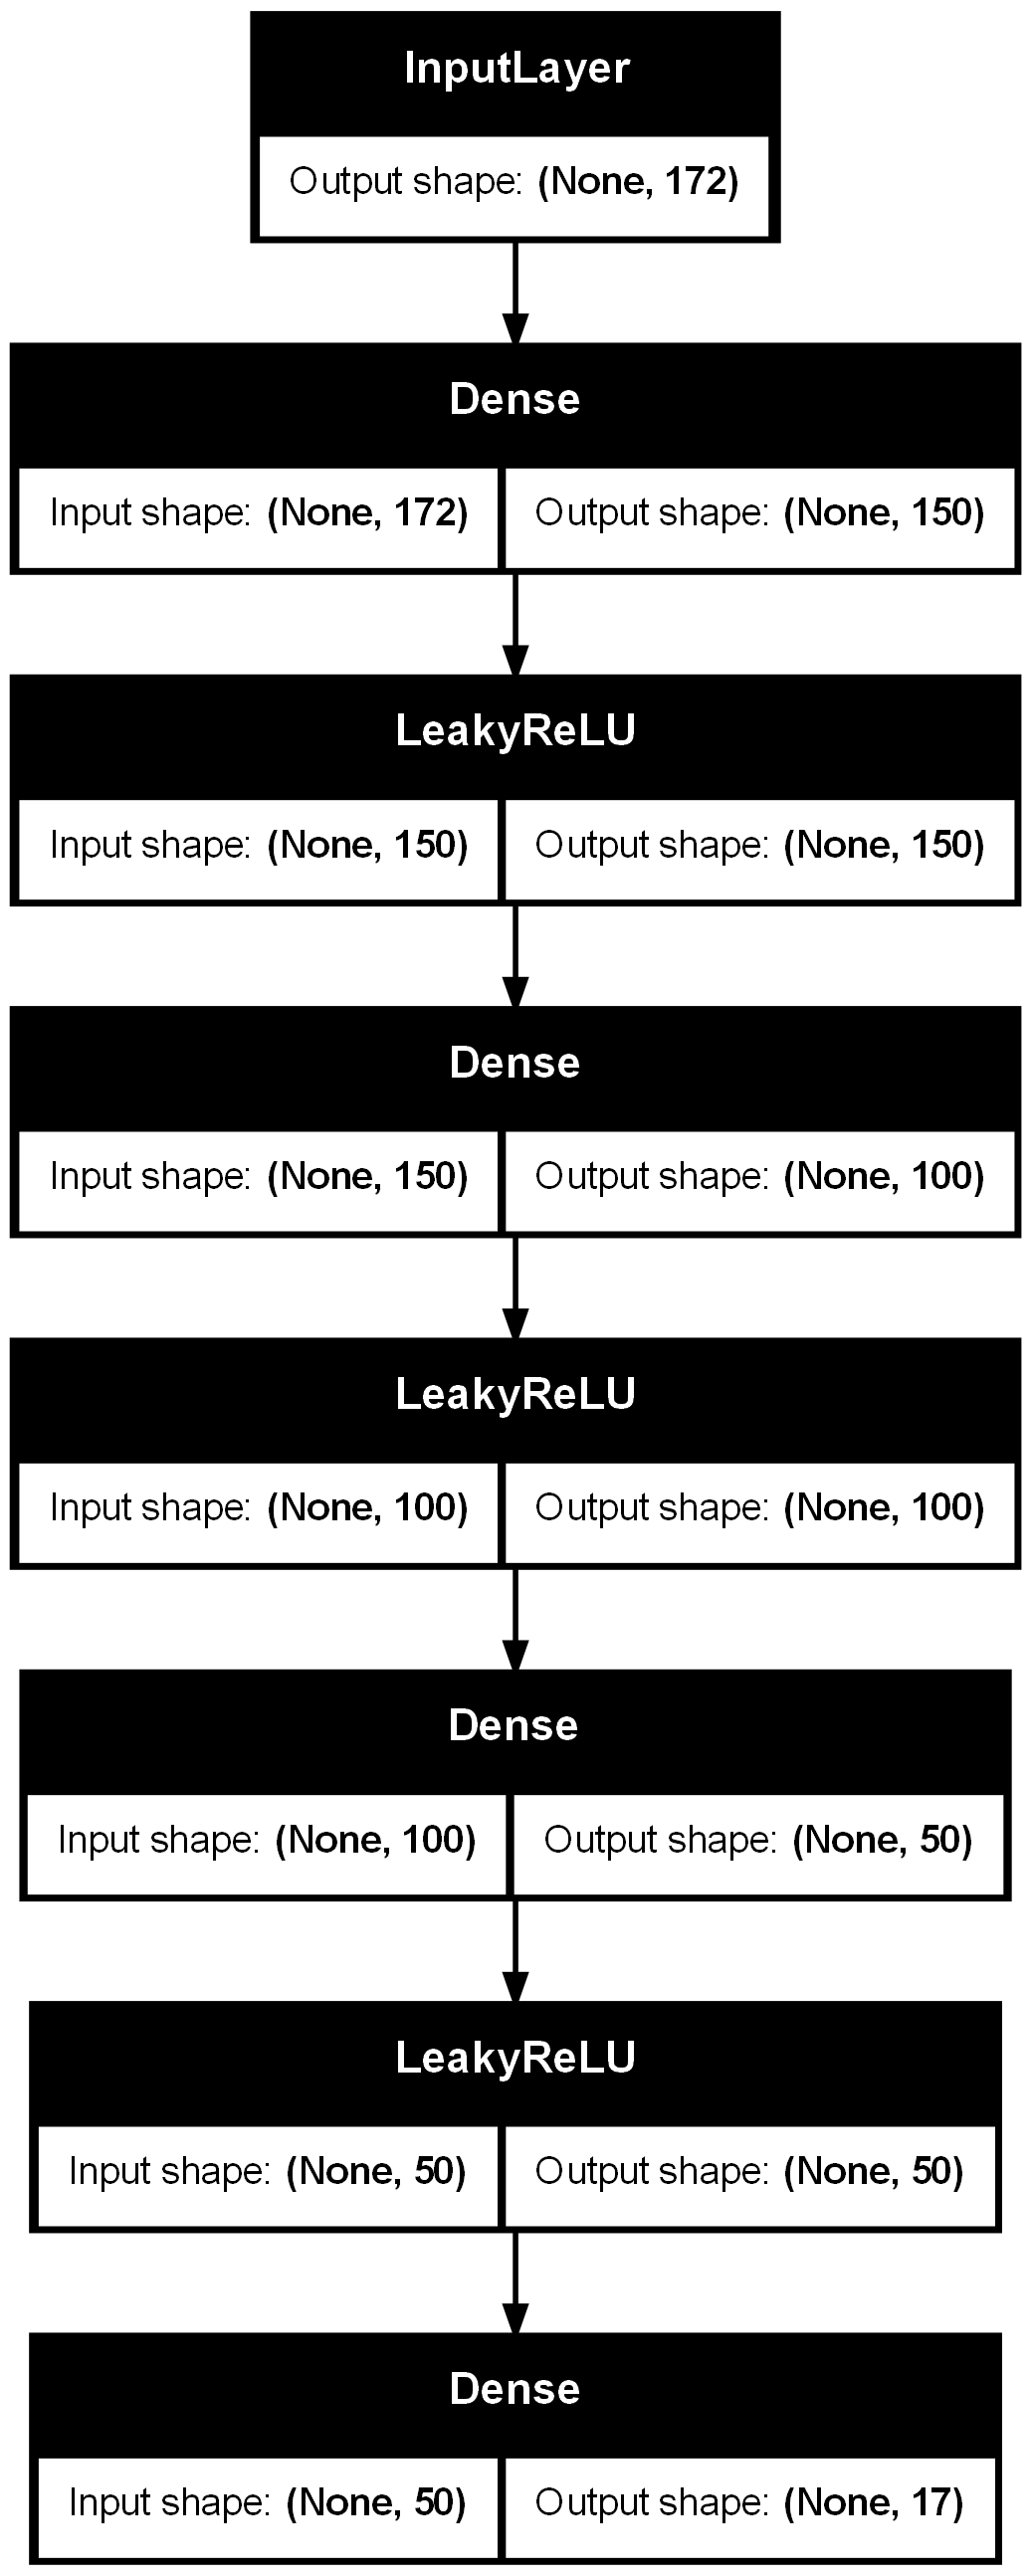

In [503]:
keras.utils.plot_model(model, show_shapes = True)

In [505]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.sparse_categorical_accuracy],
)

history = model.fit(X_train, y_train, batch_size = 64, epochs=50, validation_split=.2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4848 - sparse_categorical_accuracy: 0.2861 - val_loss: 1.9181 - val_sparse_categorical_accuracy: 0.3582
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6582 - sparse_categorical_accuracy: 0.4276 - val_loss: 1.7515 - val_sparse_categorical_accuracy: 0.4030
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5151 - sparse_categorical_accuracy: 0.5110 - val_loss: 1.6463 - val_sparse_categorical_accuracy: 0.4876
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4054 - sparse_categorical_accuracy: 0.5409 - val_loss: 1.5528 - val_sparse_categorical_accuracy: 0.5323
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3361 - sparse_categorical_accuracy: 0.5496 - val_loss: 1.4860 - val_sparse_categorical_accuracy: 0.5473
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2286 - sparse_categorical_accuracy: 0.5768 - val_loss: 1.4229 - val_sparse_categorical_accuracy: 0.5672
Epoch 7/50
13/13

In [507]:
scores = model.evaluate(X_test, y_test, verbose=2)

95/95 - 0s - 611us/step - loss: 1.5504 - sparse_categorical_accuracy: 0.6015


In [509]:
y_pred_prob = model.predict(X_test)  # Get predicted probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=pred_columns, index = actual_columns)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


,Predicted Argentina,Predicted Australia,Predicted Austria,Predicted Canada,Predicted Chile,Predicted France,Predicted Germany,Predicted Greece,Predicted Hungary,Predicted Italy,Predicted Japan,Predicted Korea,Predicted New Zealand,Predicted Portugal,Predicted Spain,Predicted USA,Predicted the Republic of South Africa
Actual Argentina,8,8,0,0,2,8,0,0,0,0,0,0,0,0,0,14,0
Actual Australia,0,111,0,0,9,91,0,0,0,2,0,0,1,0,0,60,0
Actual Austria,0,2,1,0,0,5,0,0,0,4,0,0,0,0,0,7,1
Actual Canada,0,0,1,0,3,3,0,0,0,1,0,0,5,0,0,2,0
Actual Chile,0,36,0,0,58,67,0,0,0,1,0,0,3,0,0,55,2
Actual France,2,78,0,0,34,727,0,0,0,11,0,0,11,0,0,169,13
Actual Germany,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Actual Greece,0,1,0,0,1,5,0,4,0,0,0,0,0,0,0,1,2
Actual Hungary,1,0,0,0,3,1,0,0,0,2,0,0,1,0,0,3,0
Actual Italy,0,10,1,0,5,36,0,0,0,468,0,0,2,0,0,25,2


While adding more layers and changing the activation function did seem to reduce overfitting, it did not result in better overall accuracy. Overfitting seems to be the biggest issue the model is facing, so now we will add in dropout layers to attempt to solve this problem.

In [522]:
inputs = keras.Input(shape=(172,))
x = layers.Dense(150)(inputs)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=.1)(x) # Try to avoid overfitting with dropout layers
x = layers.Dense(100)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate = .1)(x)
x = layers.Dense(50)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate = .1)(x)
outputs = layers.Dense(17, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="nation_model")
model.summary()

Model: "nation_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)          │ (None, 172)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_173 (Dense)                    │ (None, 150)                 │          25,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_174 (Dense)                    │ (None, 100)                 │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_175 (Dense)                    │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_176 (Dense)                    │ (None, 17)                  │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,967 (183.46 KB)

 Trainable params: 46,967 (183.46 KB)

 Non-trainable params: 0 (0.00 B)

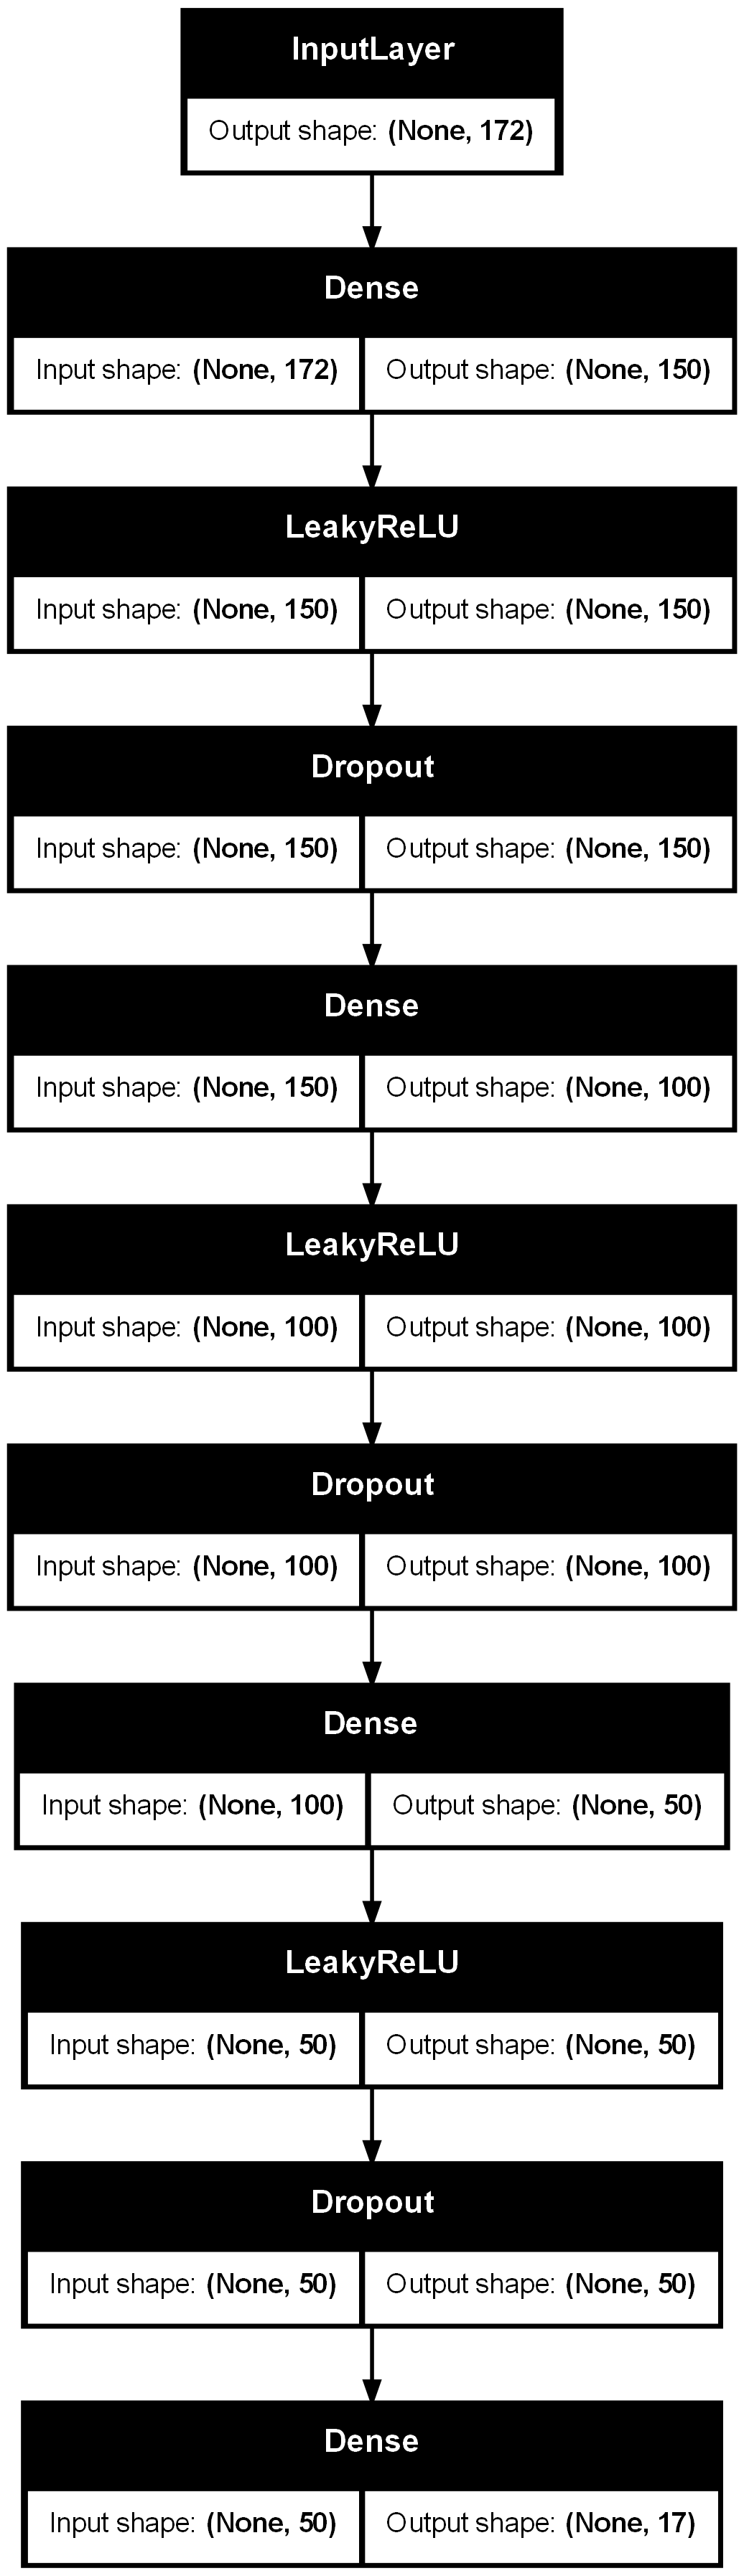

In [524]:
keras.utils.plot_model(model, show_shapes = True)

In [526]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.sparse_categorical_accuracy],
)

history = model.fit(X_train, y_train, batch_size = 64, epochs=50, validation_split=.2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4751 - sparse_categorical_accuracy: 0.2408 - val_loss: 1.9225 - val_sparse_categorical_accuracy: 0.3532
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7749 - sparse_categorical_accuracy: 0.3646 - val_loss: 1.7797 - val_sparse_categorical_accuracy: 0.4030
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5812 - sparse_categorical_accuracy: 0.4172 - val_loss: 1.6780 - val_sparse_categorical_accuracy: 0.4876
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5101 - sparse_categorical_accuracy: 0.4746 - val_loss: 1.5991 - val_sparse_categorical_accuracy: 0.4876
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4088 - sparse_categorical_accuracy: 0.5008 - val_loss: 1.5236 - val_sparse_categorical_accuracy: 0.5124
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3181 - sparse_categorical_accuracy: 0.5489 - val_loss: 1.4501 - val_sparse_categorical_accuracy: 0.5423
Epoch 7/50
13/13

In [528]:
scores = model.evaluate(X_test, y_test, verbose=2)

95/95 - 0s - 632us/step - loss: 1.3974 - sparse_categorical_accuracy: 0.6273


In [530]:
y_pred_prob = model.predict(X_test)  # Get predicted probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=pred_columns, index = actual_columns)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


,Predicted Argentina,Predicted Australia,Predicted Austria,Predicted Canada,Predicted Chile,Predicted France,Predicted Germany,Predicted Greece,Predicted Hungary,Predicted Italy,Predicted Japan,Predicted Korea,Predicted New Zealand,Predicted Portugal,Predicted Spain,Predicted USA,Predicted the Republic of South Africa
Actual Argentina,8,3,0,0,3,8,0,0,0,2,0,0,0,0,0,15,1
Actual Australia,0,81,0,0,10,113,0,0,0,7,0,0,3,0,0,57,3
Actual Austria,0,2,0,0,2,4,0,0,0,6,0,0,1,0,0,5,0
Actual Canada,0,0,0,2,3,3,0,1,0,1,0,0,1,0,0,4,0
Actual Chile,0,23,0,0,58,78,0,0,0,1,0,0,7,0,0,52,3
Actual France,1,28,0,0,23,818,0,0,0,19,0,0,13,0,0,133,10
Actual Germany,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Actual Greece,0,0,0,0,1,4,0,3,0,4,0,0,1,0,0,1,0
Actual Hungary,0,0,0,1,1,2,0,0,0,2,0,0,1,0,0,4,0
Actual Italy,0,3,0,0,7,37,0,0,0,481,0,0,3,0,0,17,1


Adding in the dropout layers did increase the overall accuracy and assist in reducing overfitting. I believe to further improve performance, more parameters are necessary and some different types of layers could be useful.